In [ ]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

# **Ejercicio 1**

Ejercicio 1:
Resuelva la ecuación de Poisson sobre un cuadrado unitario, con condiciones de Dirichlet cero en las fronteras.

$$\begin{eqnarray*}
- \nabla^2 u(x,y) & = & \cos(2\pi x) \sin(3\pi y) \\
 \mathrm{dadas \ las \ condiciones}\\ 
u(0,y) & = & 0 \\
u(1,y) & = & 0 \\
u(x,0) & = & 0 \\
u(x,1) & = & 0
\end{eqnarray*}$$

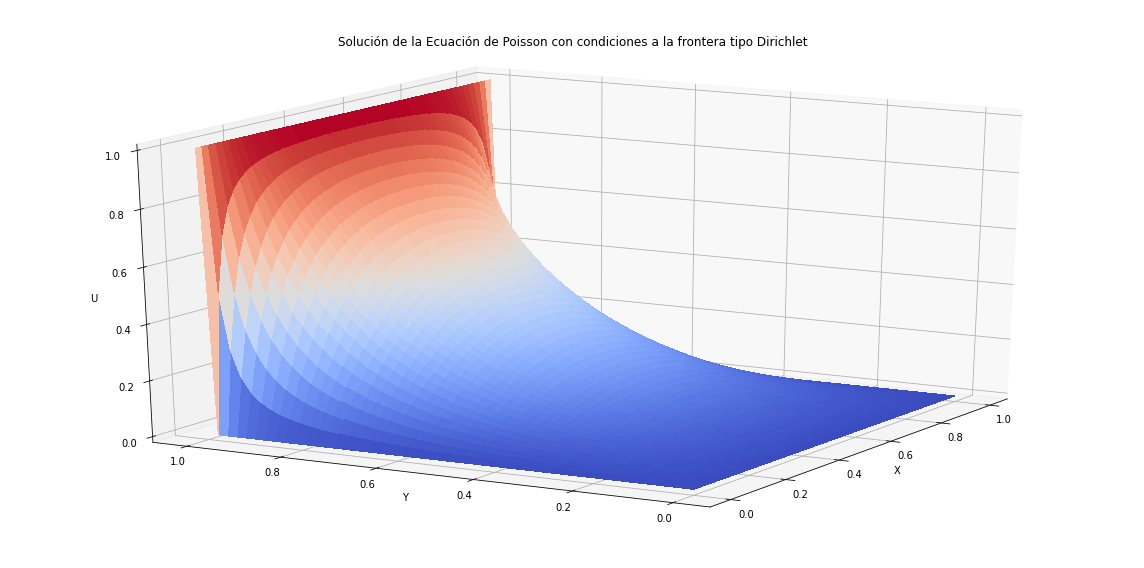

In [ ]:
def rhs_func(x, y, M):
    ###----- Element-wise multiplication -----###
    g = (1*np.multiply(np.cos(2*np.pi*X[1:-1,1:-1]), np.sin(3*np.pi*Y[1:-1,1:-1]))).flatten()
    f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
    f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
    return f


def bc_dirichlet(x, y, m):
    ###----- Initializes boundary condition values -----###
    lBC = np.zeros((M,1)).flatten() 
    leftBC = lBC[1:M-1]
    
    rBC = np.zeros((M,1)).flatten()
    rightBC = rBC[1:M-1]
    
    tBC =np.zeros((1,M)).flatten() 
    topBC = tBC[1:M-1]
    
    bBC = np.ones((1,M)).flatten()
    bottomBC = bBC[1:M-1]
    
    ###----- Creates a ((M-2)**2, ) array of zeros -----###
    g1 = np.zeros(((M-2)**2, 1)).flatten()
    
    ###----- Fills in the top BC (red circles on p. 21) -----###
    for i in range(M-2):
        g1[(M-2)*i] = topBC[i] 
    
    ###----- Fills in the bottom BC (blue circles on p. 21) -----###
    for j in range(M-2):
        g1[(M-2)*(j+1)-1] = bottomBC[j]
    
    ###----- Fills in the left BC (top orange circle on p. 21) -----###
    k1 = np.zeros((len(leftBC),1))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1,leftBC).toarray().flatten()
    
    ###----- Fills in the right BC (bottom orange circle on p. 21) -----###
    k2 = np.zeros((len(rightBC),1))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    ###----- Collects all -----###
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]
    

def generate_lhs_matrix(M, hx, hy):
    
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones((M - 2, 1)).ravel()
    off_diag = -1 * np.ones((M - 2, 1)).ravel()
    
    a = main_diag.shape[0]

    diagonals = [main_diag, off_diag, off_diag]

    B = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    
    C = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
        
    e1 = sparse.eye(M-2).toarray()
    
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M-2,M-2)).toarray()
    
    A2 = sparse.kron(e2,C).toarray()
    
    mat = A1 + A2

    return mat


###========================================###

M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

###----- Generates a grid ----###
X, Y = np.meshgrid(x1, y1)

###----- The right hand side function ----###
frhs = rhs_func(X, Y, M)

###----- Boundary conditions ----###
fbc = bc_dirichlet(X, Y, M)

rhs = frhs*(hx**2) + fbc[0]

A = generate_lhs_matrix(M, hx, hy)

###----- Solves A*x=b --> x=A\b ----###
V = np.linalg.solve(A,rhs)

###----- Reshapes the 1D array into a 2D array -----###
V = V.reshape((M-2, M-2)).T

###----- Fills in boundary values for Dirichlet BC -----###
U = np.zeros((M,M))

U[1:M-1, 1:M-1] = V
U[:,0] = fbc[1]
U[0,:] = fbc[2]
U[:,M-1] = fbc[3]
U[M-1,:] = fbc[4]

###----- Plots -----###
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

###----- Static image -----###
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Dirichlet")
plt.tight_layout()
ax.view_init(20, -150)
plt.show()


# **Ejercicio 2**

Resuelva la ecuación de Poisson sobre un cuadrado unitario, para encontrar los modos de vibración de una membrana:
$$\begin{eqnarray*}
- \nabla^2 u(x,y) & = & \sin(n\pi x) \sin(m\pi y) \\
 \mathrm{dadas \ las \ condiciones}& &  \\ 
u(0,y) & = & 0 \\
u(1,y) & = & 0 \\
u(x,0) & = & 0 \\
u(x,1) & = & 0
\end{eqnarray*}$$

para los siguientes casos:
* $n=1; m=1$, modo (1,1)
* $n=1; m=3$, modo (1,3)
* $n=2; m=2$, modo (2,2)

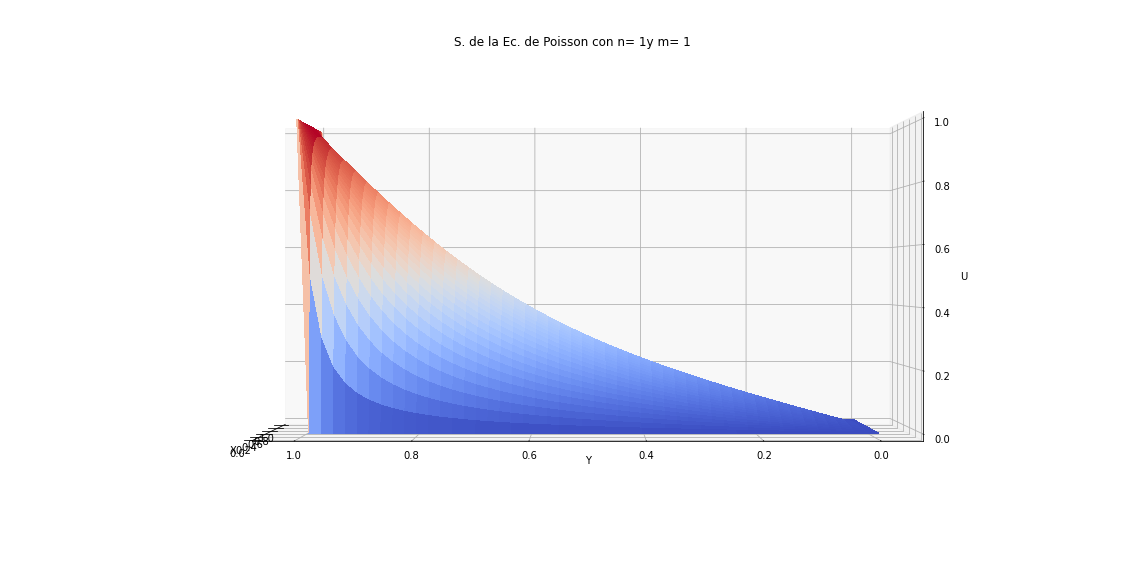

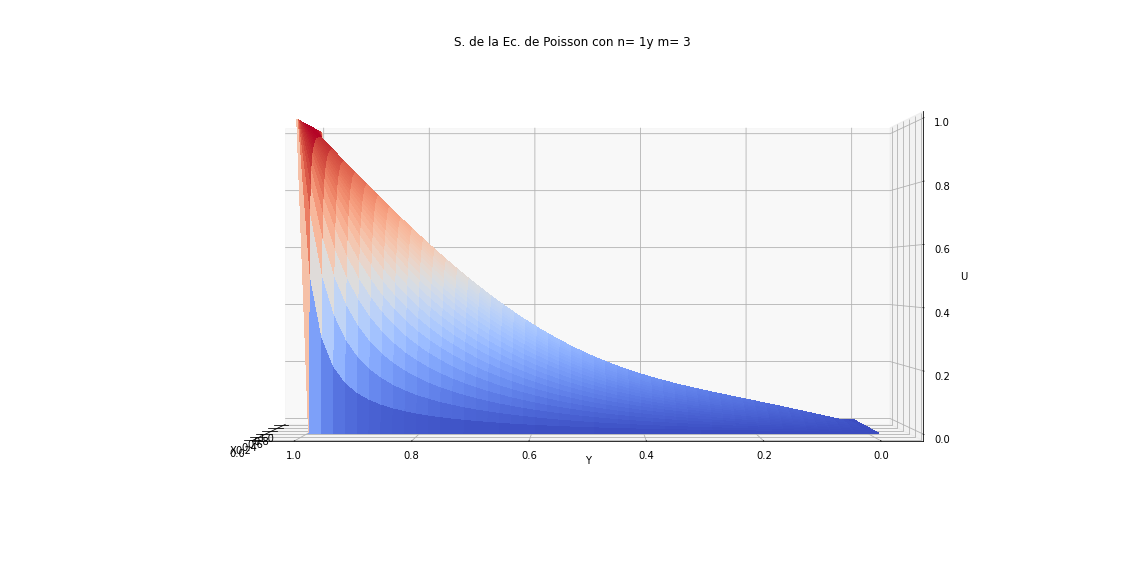

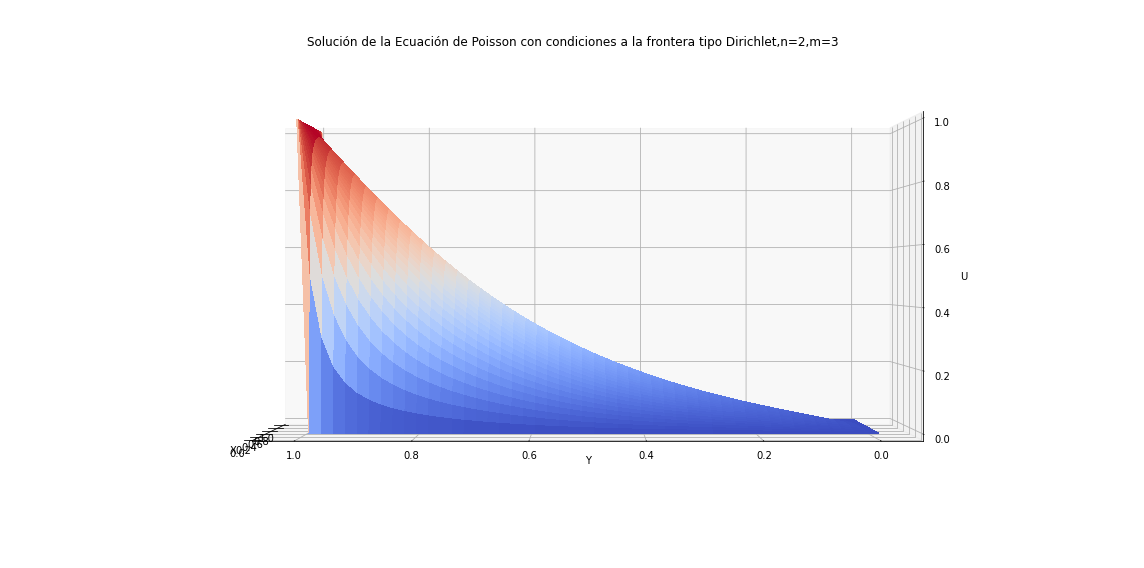

In [ ]:
def rhs_func(x, y, M, n , d ):
    ###----- Element-wise multiplication -----###
    g = (1 * np.multiply(np.sin(n*np.pi*X[1:-1,1:-1]), np.sin(d*np.pi*Y[1:-1,1:-1]))).flatten()
    f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
    f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
    return f


def bc_dirichlet(x, y, m):
    ###----- Initializes boundary condition values -----###
    lBC = np.zeros((M,1)).flatten()
    leftBC = lBC[1:M-1]
    
    rBC = np.zeros((M,1)).flatten()
    rightBC = rBC[1:M-1]
    
    tBC =np.zeros((1,M)).flatten() 
    topBC = tBC[1:M-1]
    
    bBC = np.ones((1,M)).flatten()
    bottomBC = bBC[1:M-1]
    
    ###----- Creates a ((M-2)**2, ) array of zeros -----###
    g1 = np.zeros(((M-2)**2, 1)).flatten()
    
    ###----- Fills in the top BC (red circles on p. 21) -----###
    for i in range(M-2):
        g1[(M-2)*i] = topBC[i] 
    
    ###----- Fills in the bottom BC (blue circles on p. 21) -----###
    for j in range(M-2):
        g1[(M-2)*(j+1)-1] = bottomBC[j]
    
    ###----- Fills in the left BC (top orange circle on p. 21) -----###
    k1 = np.zeros((len(leftBC),1))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1,leftBC).toarray().flatten()
    
    ###----- Fills in the right BC (bottom orange circle on p. 21) -----###
    k2 = np.zeros((len(rightBC),1))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    ###----- Collects all -----###
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]
    

def generate_lhs_matrix(M, hx, hy):
    
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones((M - 2, 1)).ravel()
    off_diag = -1 * np.ones((M - 2, 1)).ravel()
    
    a = main_diag.shape[0]

    diagonals = [main_diag, off_diag, off_diag]

    B = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    
    C = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
        
    e1 = sparse.eye(M-2).toarray()
    
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M-2,M-2)).toarray()
    
    A2 = sparse.kron(e2,C).toarray()
    
    mat = A1 + A2

    return mat


###========================================###

M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

###----- Generates a grid ----###
X, Y = np.meshgrid(x1, y1)

###----- The right hand side function ----###
#####frhs = rhs_func(X, Y, M , n , d)

###----- Boundary conditions ----###
fbc = bc_dirichlet(X, Y, M)

#####rhs = frhs*(hx**2) + fbc[0]

A = generate_lhs_matrix(M, hx, hy)

###----- Solves A*x=b --> x=A\b ----###
######V = np.linalg.solve(A,rhs)

###----- Reshapes the 1D array into a 2D array -----###
#######V = V.reshape((M-2, M-2)).T

###----- Fills in boundary values for Dirichlet BC -----###
########U = np.zeros((M,M))
for n in ([1]):
  for d in ([1,3]):
    frhs = rhs_func(X, Y, M , n , d)
    rhs = frhs*(hx**2) + fbc[0]
    V = np.linalg.solve(A,rhs)
    V = V.reshape((M-2, M-2)).T
    U = np.zeros((M,M))
    U[1:M-1, 1:M-1] = V
    U[:,0] = fbc[1]
    U[0,:] = fbc[2]
    U[:,M-1] = fbc[3]
    U[M-1,:] = fbc[4]
    ###----- Plots -----###
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    ###----- Static image -----###
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    label='S. de la Ec. de Poisson con n= '+str(n)+'y m= '+str(d)
    ax.set_title(label)
    plt.tight_layout()
    ax.view_init(0, -180)
    plt.show()
n,d=2,3
frhs = rhs_func(X, Y, M , n , d)
rhs = frhs*(hx**2) + fbc[0]
V = np.linalg.solve(A,rhs)
V = V.reshape((M-2, M-2)).T
U = np.zeros((M,M))
U[1:M-1, 1:M-1] = V
U[:,0] = fbc[1]
U[0,:] = fbc[2]
U[:,M-1] = fbc[3]
U[M-1,:] = fbc[4]
###----- Plots -----###
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)

###----- Static image -----###
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Dirichlet,n=2,m=3")
plt.tight_layout()
ax.view_init(0, -180)
plt.show()

# **Ejercicio 3**

Resuelva la ecuación de Poisson sobre un cuadrado unitario

$$\begin{equation*}
- \nabla^2 u(x,y)  =  - \pi \cos(\pi x) - \pi \cos (\pi y) 
\end{equation*}$$

con condiciones de flujo cero en las fronteras (condiciones de frontera tipo Neumann).
$$\begin{eqnarray*}
u_x(0,y) & = & 0 \\
u_x(1,y) & = & 0 \\
u_y(x,0) & = & 0 \\
u_y(x,1) & = & 0
\end{eqnarray*}$$

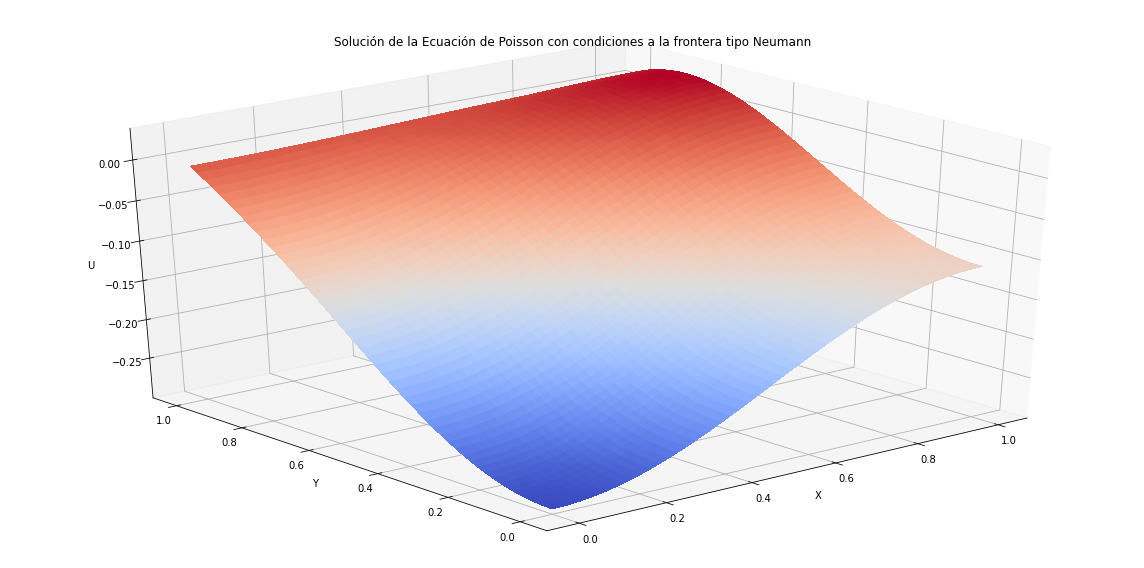

In [ ]:
def rhs_func(X, Y, M):
    ###----- Right hand side, element-wise multiplication -----###
    g =  (-1*np.cos(np.pi*X)- np.cos(np.pi*Y)).flatten()
    f = [g[i::M] for i in range(M)]
    f = np.asarray(f).flatten()
    return f
    
  
def generate_lhs_matrix(M, hx, hy):
    alpha = hx**2/hy**2
    
    main_diag = 2*(1+alpha)*np.ones((M, 1)).ravel()
    off_diag = -1*np.ones((M-1, 1)).ravel()
    
    a = main_diag.shape[0]
    
    diagonals = [main_diag, off_diag, off_diag]
    
    B = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    B[0,1] = -2.0
    #B[M-1,M-2] = -2.0
    
    D = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    C = sparse.diags([-2*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    e1 = sparse.eye(M).toarray()
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e2[0,1] = 0.0
    e2[M-1,M-2] = 0.0
    A2 = sparse.kron(e2,D).toarray()
    
    e3 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e3[1:M-1,0:M] = 0.0
    A3 = sparse.kron(e3,C).toarray()
    
    mat = A1 + A2 + A3
    
    return mat
    
#########################################

    
M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))

f = rhs_func(X, Y, M)

A = generate_lhs_matrix(M, hx, hy)

U = np.linalg.solve(A,f*(hx**2)) # Solve x=A\b

U = U.reshape((M,M)).T

## The zero-flux boundary conditions are incorporated in
## matrix A.


fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_zlim3d()
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Neumann")
plt.tight_layout()
ax.view_init(30, -130)
plt.show()


# **Ejercicio 4**

Resuelva la ecuación de Poisson sobre un cuadrado unitario

$$\begin{equation*}
- \nabla^2 u(x,y)  =  - 2 \pi^2 \sin(\pi (x+y)) 
\end{equation*}$$

con condiciones de flujo cero en las fronteras (condiciones de frontera tipo Neumann).
$$\begin{eqnarray*}
u_x(0,y) & = & 0 \\
u_x(1,y) & = & 0 \\
u_y(x,0) & = & 0 \\
u_y(x,1) & = & 0
\end{eqnarray*}$$

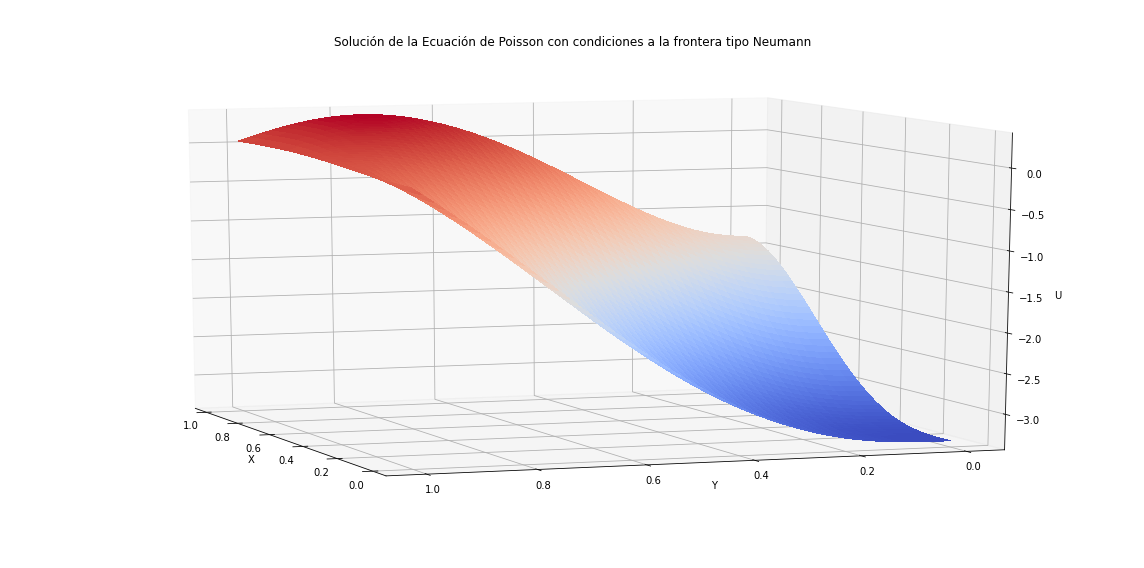

In [ ]:
def rhs_func(X, Y, M):
    ###----- Right hand side, element-wise multiplication -----###
    g = (-2*(np.pi**2)*(np.sin(np.pi*X+np.pi*Y))).flatten()
    f = [g[i::M] for i in range(M)]
    f = np.asarray(f).flatten()
    return f
    
  
def generate_lhs_matrix(M, hx, hy):
    alpha = hx**2/hy**2
    
    main_diag = 2*(1+alpha)*np.ones((M, 1)).ravel()
    off_diag = -1*np.ones((M-1, 1)).ravel()
    
    a = main_diag.shape[0]
    
    diagonals = [main_diag, off_diag, off_diag]
    
    B = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    B[0,1] = -2.0
    #B[M-1,M-2] = -2.0
    
    D = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    C = sparse.diags([-2*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    e1 = sparse.eye(M).toarray()
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e2[0,1] = 0.0
    e2[M-1,M-2] = 0.0
    A2 = sparse.kron(e2,D).toarray()
    
    e3 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e3[1:M-1,0:M] = 0.0
    A3 = sparse.kron(e3,C).toarray()
    
    mat = A1 + A2 + A3
    
    return mat
    
#########################################

    
M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))

f = rhs_func(X, Y, M)

A = generate_lhs_matrix(M, hx, hy)

U = np.linalg.solve(A,f*(hx**2)) # Solve x=A\b

U = U.reshape((M,M)).T

## The zero-flux boundary conditions are incorporated in
## matrix A.


fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_zlim3d()
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Neumann")
plt.tight_layout()
ax.view_init(10, -200)
plt.show()